In [1]:
import numpy as np
import random
import itertools
from operator import attrgetter
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
hand_score_map = {
    1: "High Card",
    2: "Pair",
    3: "Two Pair",
    4: "Trips",
    5: "Straight",
    6: "Flush",
    7: "Full House",
    8: "Quads",
    9: "Straight Flush",
    10: "Royal Flush"
}

In [94]:
suits = {'Hearts', 'Clubs', 'Spades', 'Diamonds'}

card_name_map = {
            'Two': 2,
            'Three': 3,
            'Four': 4,
            'Five': 5,
            'Six': 6,
            'Seven': 7,
            'Eight': 8,
            'Nine': 9,
            'Ten': 10,
            'Jack': 11, 
            'Queen': 12, 
            'King': 13, 
            'Ace': 14
            }

card_plural_name_map = {name: '{}s'.format(name) for name in card_name_map}
card_plural_name_map['Six'] = 'Sixes'

card_value_map = dict((reversed(item) for item in card_name_map.items()))

In [4]:
class Card:
    def __init__(self, name, suit):
        self.suit = suit
        self.name = name
        if self.name == 'Six':
            self.name_plural = 'Sixes'
        else:
            self.name_plural = self.name + 's'
        self.value = card_name_map[self.name]
    
    def __str__(self):
        return '{} of {}'.format(self.name, self.suit)

In [5]:
class Deck:
    def __init__(self):
        self.deck = []
        for suit in suits:
            for card_name in card_name_map:
                self.deck.append(Card(card_name, suit))
        self.shuffle()
                
    def __str__(self):
        return ''.join(['{} \n'.format(card) for card in self.deck])
    
    def shuffle(self):
        random.shuffle(self.deck)
    
    def draw(self):
        return self.deck.pop(0)
        

In [6]:
class Player:
    def __init__(self, name, chips):
        self.chips = chips
        self.name = name
        self.hand = []
        self.possible_hands = []
        self.best_hand = {}
        self.pre_bet_moves = {'check', 'bet'}
        self.post_bet_moves = {'fold', 'call', 'raise'}
        
    def __str__(self):
        return '{}{}'.format('Player: {}\nChips: {}\n'.format(self.name, self.chips), ''.join(['{} \n'.format(card) for card in self.hand]))
    
    def bet(self, amount):
        self.chips -= amount
        return amount
    
    
    

In [7]:
class Table:
    def __init__(self, deck):
        self.deck = deck
        self.cards = []
    

In [114]:
class Game:
    def __init__(self, players, buy_in):
        self.players = [Player('{}'.format(i), buy_in) for i in range(players)]
        self.deck = Deck()
        self.table = Table(self.deck)
        self.pot = 0
        
        
    def __str__(self):
        return ''.join(['{}\n'.format(player) for player in self.players])
        
    def deal(self):
        [[player.hand.append(card) for card in [self.deck.draw() for i in range(2)]] for player in self.players]
        
    def flop(self):
        temp_flop = []
        for i in range(3):
            card = self.deck.draw()
            self.table.cards.append(card)
            temp_flop.append(card)
        
        return ''.join(['{}\n'.format(card) for card in temp_flop])
    
    def turn(self):
        temp_turn = self.deck.draw()
        self.table.cards.append(temp_turn)
        return temp_turn
    
    def river(self):
        temp_river = self.deck.draw()
        self.table.cards.append(temp_river)
        return temp_river

#     def get_nuts(self):
    
    def get_winning_hand(self):
        return sorted([self.get_best_hand(player) for player in self.players], key=lambda x: x['score'])[::-1][0]
        
    def get_best_hand(self, player):
        return self.evaluate_possible_hands(player)[0]
        
    def evaluate_possible_hands(self, player):
        return sorted([{'hand': [str(card) for card in res['hand']], 'name': res['name'], 'score': res['score']} for res in [self.evaluate_hand(comb) for comb in self.get_possible_hands(player)]], key=lambda x: x['score'])[::-1]
        
    def get_possible_hands(self, player):
        maxScore = 0
        cards = player.hand[:] + self.table.cards[:]
        combs = []
        for comb in itertools.combinations(cards, 5):
            combs.append(list(comb))
        return combs
        
    def evaluate_hand(self, cards):
        royal_flag = False
        flush_flag = False
        straight_flag = False

        quads_flag = False
        quads_card = None
        quads_kicker = None

        full_house_flag = False
        full_house_trips_card = None
        full_house_pair_card = None

        trips_flag = False
        trips_card = None
        trips_kicker = None

        two_pair_flag = False
        top_pair_card = None
        bottom_pair_card = None

        pair_flag = False
        pair_card = None
        pair_kicker = None

        max_card = max(cards, key=attrgetter('value'))
        max_card_name = max_card.name

        card_count_map = defaultdict(int)
        card_suit_map = defaultdict(int)

        for card in cards:
            card_count_map[card.value] += 1
            card_suit_map[card.suit] += 1

    #     print(card_count_map)
    #     print(card_suit_map)
        for card in card_count_map:
            if card_count_map[card] == 4:
                quads_flag = True
                quads_card = card_value_map[card]
            if card_count_map[card] == 3:
                trips_flag = True
                trips_card = card_value_map[card]
            if card_count_map[card] == 2:
                pair_flag = True
                pair_card = card_value_map[card]
        
        if quads_flag:
            for card in card_count_map:
                if card_value_map[card] != quads_card:
                    quads_kicker = card_value_map[card]
        
        if trips_flag and not pair_flag:
            pair_flag = False
            trips_kicker = max([]) #take the max of the remaining cards (not the trips card)
                    
        if trips_flag and pair_flag:
            full_house_flag = True
            trips_flag = False
            pair_flag = False
            full_house_trips_card = trips_card
            full_house_pair_card = pair_card

        # Check for a flush
        flush_flag = len(card_suit_map) == 1

        # Check for a straight
        straight_flag = True
        # Sort cards by increasing rank
        cards.sort(key=lambda card_: card_.value)
        for i in range(1, len(cards)):
            if cards[i].value - 1 != cards[i - 1].value:
                straight_flag = False

        # Check for royal flush
        if straight_flag and flush_flag:
            royal_flag = 14 in card_count_map and 13 in card_count_map and 12 in card_count_map and 11 in card_count_map and 10 in card_count_map
            if royal_flag:
                return {
                    "hand": cards,
                    "name": "Royal Flush",
                    "score": 10
                }
            else:
                return {
                    "hand": cards,
                    "name": "{} High Straight Flush".format(max_card_name),
                    "score": 9
                }

        # Check for four of a kind, only two ways
        if cards[0].value == cards[3].value or cards[1].value == cards[4].value:
            return {
                    "hand": cards,
                    "name": "Quad {}, {} Kicker".format(card_plural_name_map[quads_card], quads_kicker),
                    "score": 8
            }

        # Check for full house
        if ((cards[0].value == cards[1].value and cards[2].value == cards[4].value) or
                (cards[0].value == cards[2].value and cards[3].value == cards[4].value)):
            return {
                    "hand": cards,
                    "name": "Full House, {} over {}".format(card_plural_name_map[full_house_trips_card], card_plural_name_map[full_house_pair_card]),
                    "score": 7
            }

        if flush_flag:
            return {
                    "hand": cards,
                    "name": "{} High Flush".format(max_card_name),
                    "score": 6
            }

        if straight_flag:
            return {
                    "hand": cards,
                    "name": "{} High Straight".format(max_card_name),
                    "score": 5
            }

        # Check for three of a kind, only three ways
        if cards[0].value == cards[2].value or (cards[1].value == cards[3].value
                                                            or cards[2].value == cards[4].value):
            return {
                    "hand": cards,
                    "name": "Trips",
                    "score": 4
            }

        # Check for two pairs, only two ways
        if ((cards[0].value == cards[1].value and cards[2].value == cards[3].value) or
                (cards[1].value == cards[2].value and cards[3].value == cards[4].value)):
            return {
                    "hand": cards,
                    "name": "Two Pair",
                    "score": 3
            }

        # Check for a single pair
        for i in range(1, len(cards)):
            if cards[i].value == cards[i - 1].value:
                pair_name = cards[i].name_plural
                return {
                    "hand": cards,
                    "name": "Pair of {}".format(pair_name),
                    "score": 2
                }


        # No combination, return high card
        return {
                    "hand": cards,
                    "name": "{} High".format(max_card_name),
                    "score": 1
                }




In [106]:
g = Game(10, 10)
g.deal()

print(g)

Player: 0
Chips: 10
Four of Spades 
Queen of Spades 

Player: 1
Chips: 10
Four of Diamonds 
Five of Clubs 

Player: 2
Chips: 10
Ace of Spades 
Jack of Clubs 

Player: 3
Chips: 10
King of Spades 
Two of Spades 

Player: 4
Chips: 10
Ten of Hearts 
Five of Spades 

Player: 5
Chips: 10
Seven of Hearts 
Nine of Spades 

Player: 6
Chips: 10
Nine of Hearts 
Jack of Hearts 

Player: 7
Chips: 10
Seven of Spades 
Eight of Spades 

Player: 8
Chips: 10
Six of Clubs 
Five of Hearts 

Player: 9
Chips: 10
Ace of Diamonds 
Ten of Clubs 




In [97]:
print(g.flop())

Seven of Spades
Eight of Clubs
Ace of Clubs



In [98]:
print(g.turn())

Nine of Spades


In [99]:
print(g.river())

Jack of Hearts


In [100]:
g.get_winning_hand()

{'hand': ['Seven of Spades',
  'Eight of Clubs',
  'Nine of Spades',
  'Ten of Diamonds',
  'Jack of Hearts'],
 'name': 'Jack High Straight',
 'score': 5}

In [110]:
def simulate(x):
    results = {i: 0 for i in range(1,11)}

    for i in range(10000):
        g = Game(x, 10)
        g.deal()
        g.flop()
        g.turn()
        g.river()
        hand = g.get_winning_hand()
        if hand['score'] == 7:
            print(hand)
        results[hand['score']] += 1

    print("{} players".format(x))
    print({hand_score_map[i]: results[i] for i in range(1, 11)})

    plt.scatter(*zip(*results.items()))
    plt.show()
    

{'hand': ['Three of Clubs', 'Three of Spades', 'Three of Hearts', 'Five of Hearts', 'Five of Clubs'], 'name': 'Full House, Threes over Fives', 'score': 7}
{'hand': ['Two of Diamonds', 'Two of Hearts', 'Two of Clubs', 'Ten of Diamonds', 'Ten of Spades'], 'name': 'Full House, Twos over Tens', 'score': 7}
{'hand': ['Eight of Clubs', 'Eight of Hearts', 'Eight of Spades', 'Ten of Spades', 'Ten of Diamonds'], 'name': 'Full House, Eights over Tens', 'score': 7}
{'hand': ['Nine of Spades', 'Nine of Hearts', 'Nine of Clubs', 'Ten of Clubs', 'Ten of Hearts'], 'name': 'Full House, Nines over Tens', 'score': 7}
{'hand': ['Nine of Spades', 'Nine of Hearts', 'Ten of Hearts', 'Ten of Clubs', 'Ten of Diamonds'], 'name': 'Full House, Tens over Nines', 'score': 7}
{'hand': ['Two of Spades', 'Two of Clubs', 'Five of Spades', 'Five of Clubs', 'Five of Diamonds'], 'name': 'Full House, Fives over Twos', 'score': 7}
{'hand': ['Nine of Clubs', 'Nine of Diamonds', 'Queen of Diamonds', 'Queen of Clubs', 'Queen 

{'hand': ['Five of Hearts', 'Five of Diamonds', 'Eight of Diamonds', 'Eight of Clubs', 'Eight of Spades'], 'name': 'Full House, Eights over Fives', 'score': 7}
{'hand': ['Nine of Diamonds', 'Nine of Clubs', 'Nine of Spades', 'Queen of Spades', 'Queen of Diamonds'], 'name': 'Full House, Nines over Queens', 'score': 7}
{'hand': ['Eight of Clubs', 'Eight of Hearts', 'Eight of Diamonds', 'Jack of Clubs', 'Jack of Spades'], 'name': 'Full House, Eights over Jacks', 'score': 7}
{'hand': ['Three of Hearts', 'Three of Diamonds', 'Eight of Clubs', 'Eight of Spades', 'Eight of Hearts'], 'name': 'Full House, Eights over Threes', 'score': 7}
{'hand': ['Seven of Diamonds', 'Seven of Clubs', 'Nine of Diamonds', 'Nine of Spades', 'Nine of Clubs'], 'name': 'Full House, Nines over Sevens', 'score': 7}
{'hand': ['King of Clubs', 'King of Diamonds', 'Ace of Hearts', 'Ace of Clubs', 'Ace of Spades'], 'name': 'Full House, Aces over Kings', 'score': 7}
{'hand': ['Seven of Hearts', 'Seven of Clubs', 'Seven of

{'hand': ['Five of Diamonds', 'Five of Hearts', 'Ace of Clubs', 'Ace of Diamonds', 'Ace of Spades'], 'name': 'Full House, Aces over Fives', 'score': 7}
{'hand': ['Four of Diamonds', 'Four of Hearts', 'Eight of Spades', 'Eight of Hearts', 'Eight of Diamonds'], 'name': 'Full House, Eights over Fours', 'score': 7}
{'hand': ['Two of Hearts', 'Two of Clubs', 'Six of Diamonds', 'Six of Clubs', 'Six of Hearts'], 'name': 'Full House, Sixes over Twos', 'score': 7}
{'hand': ['Seven of Spades', 'Seven of Hearts', 'Seven of Clubs', 'Jack of Hearts', 'Jack of Diamonds'], 'name': 'Full House, Sevens over Jacks', 'score': 7}
{'hand': ['Six of Clubs', 'Six of Spades', 'Six of Hearts', 'Queen of Hearts', 'Queen of Spades'], 'name': 'Full House, Sixes over Queens', 'score': 7}
{'hand': ['Five of Clubs', 'Five of Diamonds', 'Five of Spades', 'King of Spades', 'King of Hearts'], 'name': 'Full House, Fives over Kings', 'score': 7}
{'hand': ['Three of Hearts', 'Three of Spades', 'Three of Diamonds', 'Seven 

{'hand': ['Three of Hearts', 'Three of Spades', 'Ten of Clubs', 'Ten of Hearts', 'Ten of Spades'], 'name': 'Full House, Tens over Threes', 'score': 7}
{'hand': ['Eight of Diamonds', 'Eight of Spades', 'Jack of Hearts', 'Jack of Diamonds', 'Jack of Spades'], 'name': 'Full House, Jacks over Eights', 'score': 7}
{'hand': ['Two of Clubs', 'Two of Hearts', 'Two of Diamonds', 'Ten of Hearts', 'Ten of Clubs'], 'name': 'Full House, Twos over Tens', 'score': 7}
{'hand': ['Ten of Clubs', 'Ten of Diamonds', 'Queen of Hearts', 'Queen of Spades', 'Queen of Clubs'], 'name': 'Full House, Queens over Tens', 'score': 7}
{'hand': ['Seven of Hearts', 'Seven of Clubs', 'Seven of Spades', 'Queen of Diamonds', 'Queen of Hearts'], 'name': 'Full House, Sevens over Queens', 'score': 7}
{'hand': ['Three of Hearts', 'Three of Diamonds', 'Seven of Hearts', 'Seven of Clubs', 'Seven of Spades'], 'name': 'Full House, Sevens over Threes', 'score': 7}
{'hand': ['Two of Spades', 'Two of Diamonds', 'Seven of Spades', 'S

{'hand': ['Seven of Diamonds', 'Seven of Clubs', 'Eight of Diamonds', 'Eight of Clubs', 'Eight of Hearts'], 'name': 'Full House, Eights over Sevens', 'score': 7}
{'hand': ['Three of Hearts', 'Three of Spades', 'Three of Diamonds', 'King of Spades', 'King of Hearts'], 'name': 'Full House, Threes over Kings', 'score': 7}
{'hand': ['Five of Clubs', 'Five of Diamonds', 'King of Hearts', 'King of Spades', 'King of Diamonds'], 'name': 'Full House, Kings over Fives', 'score': 7}
{'hand': ['Two of Hearts', 'Two of Diamonds', 'Two of Clubs', 'Eight of Clubs', 'Eight of Diamonds'], 'name': 'Full House, Twos over Eights', 'score': 7}
{'hand': ['Two of Spades', 'Two of Hearts', 'Two of Clubs', 'Queen of Diamonds', 'Queen of Hearts'], 'name': 'Full House, Twos over Queens', 'score': 7}
{'hand': ['Six of Hearts', 'Six of Diamonds', 'King of Clubs', 'King of Hearts', 'King of Spades'], 'name': 'Full House, Kings over Sixes', 'score': 7}
{'hand': ['Five of Diamonds', 'Five of Spades', 'Five of Clubs',

{'hand': ['Two of Spades', 'Two of Clubs', 'Jack of Spades', 'Jack of Diamonds', 'Jack of Hearts'], 'name': 'Full House, Jacks over Twos', 'score': 7}
{'hand': ['Three of Clubs', 'Three of Diamonds', 'Four of Clubs', 'Four of Hearts', 'Four of Spades'], 'name': 'Full House, Fours over Threes', 'score': 7}
{'hand': ['Two of Spades', 'Two of Hearts', 'Two of Clubs', 'Ten of Diamonds', 'Ten of Clubs'], 'name': 'Full House, Twos over Tens', 'score': 7}
{'hand': ['Five of Diamonds', 'Five of Clubs', 'Jack of Diamonds', 'Jack of Hearts', 'Jack of Clubs'], 'name': 'Full House, Jacks over Fives', 'score': 7}
{'hand': ['Nine of Clubs', 'Nine of Hearts', 'Nine of Diamonds', 'Jack of Clubs', 'Jack of Spades'], 'name': 'Full House, Nines over Jacks', 'score': 7}
{'hand': ['Four of Clubs', 'Four of Diamonds', 'Four of Hearts', 'Six of Hearts', 'Six of Clubs'], 'name': 'Full House, Fours over Sixes', 'score': 7}
{'hand': ['Three of Clubs', 'Three of Spades', 'Jack of Clubs', 'Jack of Spades', 'Jack 

{'hand': ['Four of Hearts', 'Four of Diamonds', 'Four of Clubs', 'Ten of Clubs', 'Ten of Hearts'], 'name': 'Full House, Fours over Tens', 'score': 7}
{'hand': ['Three of Hearts', 'Three of Spades', 'Three of Clubs', 'Six of Spades', 'Six of Hearts'], 'name': 'Full House, Threes over Sixes', 'score': 7}
{'hand': ['Five of Hearts', 'Five of Clubs', 'Eight of Clubs', 'Eight of Spades', 'Eight of Hearts'], 'name': 'Full House, Eights over Fives', 'score': 7}
{'hand': ['Nine of Hearts', 'Nine of Diamonds', 'Nine of Spades', 'Jack of Clubs', 'Jack of Diamonds'], 'name': 'Full House, Nines over Jacks', 'score': 7}
{'hand': ['Jack of Diamonds', 'Jack of Hearts', 'Jack of Clubs', 'Queen of Clubs', 'Queen of Spades'], 'name': 'Full House, Jacks over Queens', 'score': 7}
{'hand': ['Eight of Diamonds', 'Eight of Spades', 'Eight of Hearts', 'Ten of Clubs', 'Ten of Spades'], 'name': 'Full House, Eights over Tens', 'score': 7}
{'hand': ['Eight of Spades', 'Eight of Diamonds', 'Eight of Hearts', 'Nine

{'hand': ['Four of Clubs', 'Four of Diamonds', 'Six of Spades', 'Six of Diamonds', 'Six of Clubs'], 'name': 'Full House, Sixes over Fours', 'score': 7}
{'hand': ['Eight of Diamonds', 'Eight of Spades', 'King of Clubs', 'King of Hearts', 'King of Diamonds'], 'name': 'Full House, Kings over Eights', 'score': 7}
{'hand': ['Two of Hearts', 'Two of Clubs', 'Nine of Clubs', 'Nine of Spades', 'Nine of Diamonds'], 'name': 'Full House, Nines over Twos', 'score': 7}
{'hand': ['Queen of Clubs', 'Queen of Diamonds', 'Queen of Spades', 'Ace of Spades', 'Ace of Hearts'], 'name': 'Full House, Queens over Aces', 'score': 7}
{'hand': ['Nine of Spades', 'Nine of Diamonds', 'Ten of Diamonds', 'Ten of Clubs', 'Ten of Spades'], 'name': 'Full House, Tens over Nines', 'score': 7}
{'hand': ['Two of Spades', 'Two of Clubs', 'Two of Hearts', 'Queen of Spades', 'Queen of Clubs'], 'name': 'Full House, Twos over Queens', 'score': 7}
{'hand': ['Six of Diamonds', 'Six of Clubs', 'Queen of Hearts', 'Queen of Clubs', 

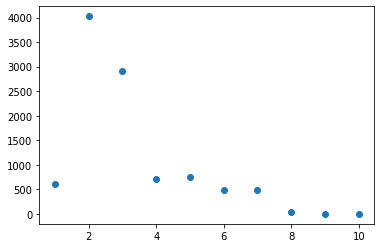

{'hand': ['Eight of Spades', 'Eight of Diamonds', 'Ten of Diamonds', 'Ten of Spades', 'Ten of Hearts'], 'name': 'Full House, Tens over Eights', 'score': 7}
{'hand': ['Two of Clubs', 'Two of Spades', 'Two of Hearts', 'Four of Diamonds', 'Four of Clubs'], 'name': 'Full House, Twos over Fours', 'score': 7}
{'hand': ['Queen of Clubs', 'Queen of Hearts', 'Queen of Diamonds', 'Ace of Diamonds', 'Ace of Spades'], 'name': 'Full House, Queens over Aces', 'score': 7}
{'hand': ['Two of Spades', 'Two of Diamonds', 'Two of Hearts', 'Five of Diamonds', 'Five of Spades'], 'name': 'Full House, Twos over Fives', 'score': 7}
{'hand': ['Six of Spades', 'Six of Clubs', 'Jack of Diamonds', 'Jack of Clubs', 'Jack of Hearts'], 'name': 'Full House, Jacks over Sixes', 'score': 7}
{'hand': ['Nine of Clubs', 'Nine of Diamonds', 'Queen of Spades', 'Queen of Diamonds', 'Queen of Clubs'], 'name': 'Full House, Queens over Nines', 'score': 7}
{'hand': ['King of Hearts', 'King of Clubs', 'Ace of Diamonds', 'Ace of Hea

{'hand': ['Three of Hearts', 'Three of Diamonds', 'Six of Hearts', 'Six of Spades', 'Six of Clubs'], 'name': 'Full House, Sixes over Threes', 'score': 7}
{'hand': ['Six of Clubs', 'Six of Diamonds', 'Six of Spades', 'Nine of Hearts', 'Nine of Diamonds'], 'name': 'Full House, Sixes over Nines', 'score': 7}
{'hand': ['Three of Clubs', 'Three of Diamonds', 'Three of Spades', 'Four of Diamonds', 'Four of Clubs'], 'name': 'Full House, Threes over Fours', 'score': 7}
{'hand': ['Six of Clubs', 'Six of Spades', 'Seven of Hearts', 'Seven of Clubs', 'Seven of Diamonds'], 'name': 'Full House, Sevens over Sixes', 'score': 7}
{'hand': ['Three of Hearts', 'Three of Clubs', 'King of Spades', 'King of Diamonds', 'King of Clubs'], 'name': 'Full House, Kings over Threes', 'score': 7}
{'hand': ['Seven of Spades', 'Seven of Hearts', 'Ten of Diamonds', 'Ten of Hearts', 'Ten of Spades'], 'name': 'Full House, Tens over Sevens', 'score': 7}
{'hand': ['Nine of Clubs', 'Nine of Hearts', 'Nine of Spades', 'Ten o

{'hand': ['Four of Diamonds', 'Four of Hearts', 'Five of Hearts', 'Five of Diamonds', 'Five of Clubs'], 'name': 'Full House, Fives over Fours', 'score': 7}
{'hand': ['Five of Spades', 'Five of Hearts', 'Five of Diamonds', 'Six of Diamonds', 'Six of Clubs'], 'name': 'Full House, Fives over Sixes', 'score': 7}
{'hand': ['Seven of Spades', 'Seven of Clubs', 'King of Hearts', 'King of Spades', 'King of Diamonds'], 'name': 'Full House, Kings over Sevens', 'score': 7}
{'hand': ['Jack of Diamonds', 'Jack of Clubs', 'Queen of Clubs', 'Queen of Spades', 'Queen of Hearts'], 'name': 'Full House, Queens over Jacks', 'score': 7}
{'hand': ['Four of Spades', 'Four of Diamonds', 'Four of Clubs', 'Five of Clubs', 'Five of Hearts'], 'name': 'Full House, Fours over Fives', 'score': 7}
{'hand': ['Two of Diamonds', 'Two of Clubs', 'Ace of Spades', 'Ace of Clubs', 'Ace of Hearts'], 'name': 'Full House, Aces over Twos', 'score': 7}
{'hand': ['Three of Spades', 'Three of Diamonds', 'Three of Hearts', 'Ten of 

{'hand': ['Seven of Diamonds', 'Seven of Clubs', 'Seven of Hearts', 'Queen of Clubs', 'Queen of Spades'], 'name': 'Full House, Sevens over Queens', 'score': 7}
{'hand': ['Two of Clubs', 'Two of Diamonds', 'Four of Hearts', 'Four of Diamonds', 'Four of Clubs'], 'name': 'Full House, Fours over Twos', 'score': 7}
{'hand': ['Two of Spades', 'Two of Diamonds', 'Seven of Diamonds', 'Seven of Spades', 'Seven of Hearts'], 'name': 'Full House, Sevens over Twos', 'score': 7}
{'hand': ['Nine of Spades', 'Nine of Hearts', 'Nine of Diamonds', 'Ten of Hearts', 'Ten of Diamonds'], 'name': 'Full House, Nines over Tens', 'score': 7}
{'hand': ['Three of Diamonds', 'Three of Clubs', 'Ten of Diamonds', 'Ten of Hearts', 'Ten of Clubs'], 'name': 'Full House, Tens over Threes', 'score': 7}
{'hand': ['Ten of Diamonds', 'Ten of Clubs', 'King of Clubs', 'King of Spades', 'King of Diamonds'], 'name': 'Full House, Kings over Tens', 'score': 7}
{'hand': ['Seven of Hearts', 'Seven of Spades', 'Seven of Clubs', 'Ten

{'hand': ['Two of Hearts', 'Two of Clubs', 'Two of Diamonds', 'Jack of Hearts', 'Jack of Clubs'], 'name': 'Full House, Twos over Jacks', 'score': 7}
{'hand': ['Nine of Hearts', 'Nine of Spades', 'Ten of Diamonds', 'Ten of Clubs', 'Ten of Spades'], 'name': 'Full House, Tens over Nines', 'score': 7}
{'hand': ['Four of Diamonds', 'Four of Clubs', 'Jack of Spades', 'Jack of Diamonds', 'Jack of Clubs'], 'name': 'Full House, Jacks over Fours', 'score': 7}
{'hand': ['Eight of Diamonds', 'Eight of Hearts', 'Eight of Clubs', 'Ace of Hearts', 'Ace of Clubs'], 'name': 'Full House, Eights over Aces', 'score': 7}
{'hand': ['Six of Clubs', 'Six of Spades', 'Six of Diamonds', 'Ten of Diamonds', 'Ten of Spades'], 'name': 'Full House, Sixes over Tens', 'score': 7}
{'hand': ['Seven of Diamonds', 'Seven of Spades', 'Seven of Clubs', 'Jack of Hearts', 'Jack of Diamonds'], 'name': 'Full House, Sevens over Jacks', 'score': 7}
{'hand': ['Two of Hearts', 'Two of Spades', 'Three of Hearts', 'Three of Clubs', '

{'hand': ['Four of Hearts', 'Four of Clubs', 'Jack of Diamonds', 'Jack of Hearts', 'Jack of Clubs'], 'name': 'Full House, Jacks over Fours', 'score': 7}
{'hand': ['Four of Diamonds', 'Four of Spades', 'Jack of Diamonds', 'Jack of Spades', 'Jack of Hearts'], 'name': 'Full House, Jacks over Fours', 'score': 7}
{'hand': ['Three of Clubs', 'Three of Hearts', 'Three of Spades', 'Eight of Spades', 'Eight of Hearts'], 'name': 'Full House, Threes over Eights', 'score': 7}
{'hand': ['Six of Spades', 'Six of Hearts', 'Six of Diamonds', 'Ace of Clubs', 'Ace of Diamonds'], 'name': 'Full House, Sixes over Aces', 'score': 7}
{'hand': ['Three of Spades', 'Three of Diamonds', 'Three of Clubs', 'Jack of Hearts', 'Jack of Spades'], 'name': 'Full House, Threes over Jacks', 'score': 7}
{'hand': ['Two of Diamonds', 'Two of Spades', 'Queen of Clubs', 'Queen of Spades', 'Queen of Hearts'], 'name': 'Full House, Queens over Twos', 'score': 7}
{'hand': ['Four of Spades', 'Four of Diamonds', 'King of Clubs', 'Ki

{'hand': ['Two of Spades', 'Two of Hearts', 'Ace of Hearts', 'Ace of Clubs', 'Ace of Spades'], 'name': 'Full House, Aces over Twos', 'score': 7}
{'hand': ['Two of Diamonds', 'Two of Hearts', 'Two of Clubs', 'Four of Diamonds', 'Four of Spades'], 'name': 'Full House, Twos over Fours', 'score': 7}
{'hand': ['Three of Diamonds', 'Three of Clubs', 'Nine of Spades', 'Nine of Hearts', 'Nine of Diamonds'], 'name': 'Full House, Nines over Threes', 'score': 7}
{'hand': ['Ten of Spades', 'Ten of Diamonds', 'Ten of Hearts', 'Queen of Clubs', 'Queen of Hearts'], 'name': 'Full House, Tens over Queens', 'score': 7}
{'hand': ['Queen of Spades', 'Queen of Diamonds', 'King of Hearts', 'King of Spades', 'King of Diamonds'], 'name': 'Full House, Kings over Queens', 'score': 7}
{'hand': ['Eight of Hearts', 'Eight of Clubs', 'Eight of Spades', 'Queen of Diamonds', 'Queen of Hearts'], 'name': 'Full House, Eights over Queens', 'score': 7}
{'hand': ['Six of Diamonds', 'Six of Spades', 'Six of Clubs', 'Jack of

{'hand': ['Three of Clubs', 'Three of Hearts', 'Three of Diamonds', 'Jack of Spades', 'Jack of Hearts'], 'name': 'Full House, Threes over Jacks', 'score': 7}
{'hand': ['Ten of Hearts', 'Ten of Diamonds', 'Ten of Clubs', 'Queen of Spades', 'Queen of Clubs'], 'name': 'Full House, Tens over Queens', 'score': 7}
{'hand': ['Three of Clubs', 'Three of Hearts', 'Eight of Hearts', 'Eight of Diamonds', 'Eight of Spades'], 'name': 'Full House, Eights over Threes', 'score': 7}
{'hand': ['Four of Hearts', 'Four of Spades', 'Queen of Clubs', 'Queen of Spades', 'Queen of Diamonds'], 'name': 'Full House, Queens over Fours', 'score': 7}
{'hand': ['Jack of Clubs', 'Jack of Hearts', 'Ace of Diamonds', 'Ace of Hearts', 'Ace of Spades'], 'name': 'Full House, Aces over Jacks', 'score': 7}
{'hand': ['Jack of Clubs', 'Jack of Diamonds', 'King of Clubs', 'King of Spades', 'King of Hearts'], 'name': 'Full House, Kings over Jacks', 'score': 7}
{'hand': ['Seven of Spades', 'Seven of Hearts', 'Seven of Diamonds',

{'hand': ['Ten of Clubs', 'Ten of Hearts', 'Ten of Spades', 'Ace of Diamonds', 'Ace of Spades'], 'name': 'Full House, Tens over Aces', 'score': 7}
{'hand': ['Ten of Clubs', 'Ten of Hearts', 'Ten of Diamonds', 'Queen of Spades', 'Queen of Diamonds'], 'name': 'Full House, Tens over Queens', 'score': 7}
{'hand': ['Three of Hearts', 'Three of Clubs', 'Six of Diamonds', 'Six of Clubs', 'Six of Hearts'], 'name': 'Full House, Sixes over Threes', 'score': 7}
{'hand': ['Three of Spades', 'Three of Diamonds', 'Eight of Hearts', 'Eight of Clubs', 'Eight of Spades'], 'name': 'Full House, Eights over Threes', 'score': 7}
{'hand': ['Nine of Hearts', 'Nine of Clubs', 'King of Clubs', 'King of Spades', 'King of Hearts'], 'name': 'Full House, Kings over Nines', 'score': 7}
{'hand': ['Four of Diamonds', 'Four of Clubs', 'Four of Spades', 'Seven of Clubs', 'Seven of Hearts'], 'name': 'Full House, Fours over Sevens', 'score': 7}
{'hand': ['Three of Clubs', 'Three of Diamonds', 'King of Clubs', 'King of He

{'hand': ['Ten of Spades', 'Ten of Hearts', 'Ten of Clubs', 'Ace of Spades', 'Ace of Diamonds'], 'name': 'Full House, Tens over Aces', 'score': 7}
{'hand': ['Four of Spades', 'Four of Clubs', 'Four of Diamonds', 'Eight of Clubs', 'Eight of Diamonds'], 'name': 'Full House, Fours over Eights', 'score': 7}
{'hand': ['Six of Diamonds', 'Six of Hearts', 'Six of Clubs', 'Ten of Hearts', 'Ten of Diamonds'], 'name': 'Full House, Sixes over Tens', 'score': 7}
{'hand': ['Seven of Spades', 'Seven of Diamonds', 'Seven of Clubs', 'Jack of Hearts', 'Jack of Clubs'], 'name': 'Full House, Sevens over Jacks', 'score': 7}
{'hand': ['Four of Spades', 'Four of Diamonds', 'Four of Clubs', 'Queen of Diamonds', 'Queen of Hearts'], 'name': 'Full House, Fours over Queens', 'score': 7}
{'hand': ['Six of Diamonds', 'Six of Hearts', 'Jack of Spades', 'Jack of Diamonds', 'Jack of Clubs'], 'name': 'Full House, Jacks over Sixes', 'score': 7}
{'hand': ['Seven of Clubs', 'Seven of Hearts', 'Seven of Diamonds', 'Eight 

{'hand': ['Six of Hearts', 'Six of Diamonds', 'Six of Spades', 'Eight of Diamonds', 'Eight of Spades'], 'name': 'Full House, Sixes over Eights', 'score': 7}
{'hand': ['Four of Diamonds', 'Four of Spades', 'Jack of Clubs', 'Jack of Hearts', 'Jack of Diamonds'], 'name': 'Full House, Jacks over Fours', 'score': 7}
{'hand': ['Two of Clubs', 'Two of Hearts', 'Two of Diamonds', 'King of Diamonds', 'King of Clubs'], 'name': 'Full House, Twos over Kings', 'score': 7}
{'hand': ['Four of Diamonds', 'Four of Hearts', 'Five of Clubs', 'Five of Diamonds', 'Five of Hearts'], 'name': 'Full House, Fives over Fours', 'score': 7}
{'hand': ['Six of Clubs', 'Six of Diamonds', 'Seven of Diamonds', 'Seven of Spades', 'Seven of Clubs'], 'name': 'Full House, Sevens over Sixes', 'score': 7}
{'hand': ['Seven of Diamonds', 'Seven of Hearts', 'Ace of Clubs', 'Ace of Diamonds', 'Ace of Spades'], 'name': 'Full House, Aces over Sevens', 'score': 7}
{'hand': ['Two of Spades', 'Two of Hearts', 'Jack of Spades', 'Jack 

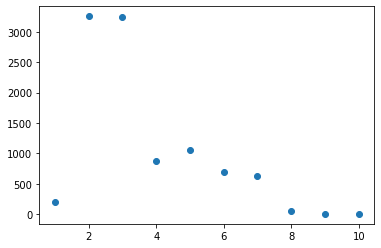

{'hand': ['Queen of Spades', 'Queen of Clubs', 'Queen of Diamonds', 'Ace of Clubs', 'Ace of Diamonds'], 'name': 'Full House, Queens over Aces', 'score': 7}
{'hand': ['Two of Diamonds', 'Two of Spades', 'Ten of Hearts', 'Ten of Clubs', 'Ten of Spades'], 'name': 'Full House, Tens over Twos', 'score': 7}
{'hand': ['Two of Hearts', 'Two of Clubs', 'Two of Spades', 'Ace of Clubs', 'Ace of Spades'], 'name': 'Full House, Twos over Aces', 'score': 7}
{'hand': ['Four of Clubs', 'Four of Spades', 'Four of Hearts', 'Eight of Clubs', 'Eight of Diamonds'], 'name': 'Full House, Fours over Eights', 'score': 7}
{'hand': ['King of Spades', 'King of Hearts', 'King of Clubs', 'Ace of Spades', 'Ace of Diamonds'], 'name': 'Full House, Kings over Aces', 'score': 7}
{'hand': ['Eight of Diamonds', 'Eight of Clubs', 'Ten of Hearts', 'Ten of Diamonds', 'Ten of Clubs'], 'name': 'Full House, Tens over Eights', 'score': 7}
{'hand': ['Ten of Diamonds', 'Ten of Hearts', 'Ten of Clubs', 'Queen of Diamonds', 'Queen of

{'hand': ['Six of Hearts', 'Six of Spades', 'Six of Diamonds', 'King of Hearts', 'King of Spades'], 'name': 'Full House, Sixes over Kings', 'score': 7}
{'hand': ['Two of Clubs', 'Two of Hearts', 'Two of Spades', 'Five of Spades', 'Five of Diamonds'], 'name': 'Full House, Twos over Fives', 'score': 7}
{'hand': ['Five of Clubs', 'Five of Spades', 'Queen of Hearts', 'Queen of Diamonds', 'Queen of Clubs'], 'name': 'Full House, Queens over Fives', 'score': 7}
{'hand': ['Two of Clubs', 'Two of Diamonds', 'Three of Spades', 'Three of Clubs', 'Three of Hearts'], 'name': 'Full House, Threes over Twos', 'score': 7}
{'hand': ['Ten of Diamonds', 'Ten of Spades', 'Ten of Clubs', 'Queen of Spades', 'Queen of Diamonds'], 'name': 'Full House, Tens over Queens', 'score': 7}
{'hand': ['Two of Diamonds', 'Two of Hearts', 'Queen of Diamonds', 'Queen of Clubs', 'Queen of Hearts'], 'name': 'Full House, Queens over Twos', 'score': 7}
{'hand': ['Jack of Diamonds', 'Jack of Clubs', 'Jack of Hearts', 'Ace of Di

{'hand': ['Nine of Diamonds', 'Nine of Spades', 'Jack of Spades', 'Jack of Diamonds', 'Jack of Hearts'], 'name': 'Full House, Jacks over Nines', 'score': 7}
{'hand': ['Ten of Clubs', 'Ten of Spades', 'Ten of Diamonds', 'Queen of Hearts', 'Queen of Diamonds'], 'name': 'Full House, Tens over Queens', 'score': 7}
{'hand': ['Five of Spades', 'Five of Clubs', 'Seven of Diamonds', 'Seven of Hearts', 'Seven of Clubs'], 'name': 'Full House, Sevens over Fives', 'score': 7}
{'hand': ['Three of Diamonds', 'Three of Clubs', 'Five of Hearts', 'Five of Diamonds', 'Five of Clubs'], 'name': 'Full House, Fives over Threes', 'score': 7}
{'hand': ['Four of Hearts', 'Four of Spades', 'Four of Clubs', 'Queen of Clubs', 'Queen of Diamonds'], 'name': 'Full House, Fours over Queens', 'score': 7}
{'hand': ['Ten of Hearts', 'Ten of Clubs', 'Ten of Diamonds', 'King of Diamonds', 'King of Spades'], 'name': 'Full House, Tens over Kings', 'score': 7}
{'hand': ['Nine of Clubs', 'Nine of Hearts', 'Nine of Diamonds', 

{'hand': ['Eight of Clubs', 'Eight of Spades', 'Ten of Spades', 'Ten of Diamonds', 'Ten of Clubs'], 'name': 'Full House, Tens over Eights', 'score': 7}
{'hand': ['Five of Hearts', 'Five of Spades', 'Five of Clubs', 'Eight of Clubs', 'Eight of Hearts'], 'name': 'Full House, Fives over Eights', 'score': 7}
{'hand': ['Eight of Diamonds', 'Eight of Hearts', 'Eight of Spades', 'King of Clubs', 'King of Spades'], 'name': 'Full House, Eights over Kings', 'score': 7}
{'hand': ['Nine of Spades', 'Nine of Diamonds', 'Queen of Diamonds', 'Queen of Clubs', 'Queen of Spades'], 'name': 'Full House, Queens over Nines', 'score': 7}
{'hand': ['Six of Diamonds', 'Six of Clubs', 'Nine of Diamonds', 'Nine of Hearts', 'Nine of Spades'], 'name': 'Full House, Nines over Sixes', 'score': 7}
{'hand': ['Four of Spades', 'Four of Clubs', 'Four of Hearts', 'Five of Diamonds', 'Five of Hearts'], 'name': 'Full House, Fours over Fives', 'score': 7}
{'hand': ['Eight of Hearts', 'Eight of Clubs', 'Ace of Diamonds', 'A

{'hand': ['Six of Diamonds', 'Six of Hearts', 'Ten of Diamonds', 'Ten of Clubs', 'Ten of Hearts'], 'name': 'Full House, Tens over Sixes', 'score': 7}
{'hand': ['Eight of Hearts', 'Eight of Clubs', 'Jack of Diamonds', 'Jack of Hearts', 'Jack of Spades'], 'name': 'Full House, Jacks over Eights', 'score': 7}
{'hand': ['Seven of Clubs', 'Seven of Hearts', 'Nine of Hearts', 'Nine of Clubs', 'Nine of Diamonds'], 'name': 'Full House, Nines over Sevens', 'score': 7}
{'hand': ['Two of Hearts', 'Two of Diamonds', 'Two of Clubs', 'Eight of Hearts', 'Eight of Clubs'], 'name': 'Full House, Twos over Eights', 'score': 7}
{'hand': ['Eight of Diamonds', 'Eight of Clubs', 'King of Spades', 'King of Diamonds', 'King of Clubs'], 'name': 'Full House, Kings over Eights', 'score': 7}
{'hand': ['Five of Spades', 'Five of Clubs', 'Seven of Spades', 'Seven of Hearts', 'Seven of Clubs'], 'name': 'Full House, Sevens over Fives', 'score': 7}
{'hand': ['Eight of Hearts', 'Eight of Diamonds', 'Ace of Spades', 'Ace 

{'hand': ['Three of Spades', 'Three of Clubs', 'Three of Diamonds', 'Nine of Clubs', 'Nine of Spades'], 'name': 'Full House, Threes over Nines', 'score': 7}
{'hand': ['Two of Hearts', 'Two of Spades', 'Jack of Clubs', 'Jack of Hearts', 'Jack of Spades'], 'name': 'Full House, Jacks over Twos', 'score': 7}
{'hand': ['Nine of Clubs', 'Nine of Hearts', 'King of Clubs', 'King of Hearts', 'King of Spades'], 'name': 'Full House, Kings over Nines', 'score': 7}
{'hand': ['Seven of Clubs', 'Seven of Diamonds', 'Seven of Spades', 'Ten of Diamonds', 'Ten of Clubs'], 'name': 'Full House, Sevens over Tens', 'score': 7}
{'hand': ['Two of Diamonds', 'Two of Clubs', 'Two of Hearts', 'Three of Diamonds', 'Three of Clubs'], 'name': 'Full House, Twos over Threes', 'score': 7}
{'hand': ['Two of Clubs', 'Two of Hearts', 'Two of Spades', 'Five of Clubs', 'Five of Hearts'], 'name': 'Full House, Twos over Fives', 'score': 7}
{'hand': ['Queen of Spades', 'Queen of Diamonds', 'Queen of Hearts', 'King of Diamonds

{'hand': ['Six of Clubs', 'Six of Diamonds', 'Six of Spades', 'Seven of Hearts', 'Seven of Clubs'], 'name': 'Full House, Sixes over Sevens', 'score': 7}
{'hand': ['Ten of Diamonds', 'Ten of Clubs', 'Ace of Spades', 'Ace of Diamonds', 'Ace of Hearts'], 'name': 'Full House, Aces over Tens', 'score': 7}
{'hand': ['Seven of Clubs', 'Seven of Diamonds', 'King of Hearts', 'King of Clubs', 'King of Spades'], 'name': 'Full House, Kings over Sevens', 'score': 7}
{'hand': ['Eight of Clubs', 'Eight of Hearts', 'Eight of Diamonds', 'Ace of Hearts', 'Ace of Clubs'], 'name': 'Full House, Eights over Aces', 'score': 7}
{'hand': ['Three of Diamonds', 'Three of Clubs', 'Three of Hearts', 'Nine of Diamonds', 'Nine of Clubs'], 'name': 'Full House, Threes over Nines', 'score': 7}
{'hand': ['Eight of Diamonds', 'Eight of Spades', 'Eight of Clubs', 'King of Hearts', 'King of Diamonds'], 'name': 'Full House, Eights over Kings', 'score': 7}
{'hand': ['Jack of Diamonds', 'Jack of Spades', 'Jack of Hearts', 'Ki

{'hand': ['Five of Clubs', 'Five of Hearts', 'Nine of Spades', 'Nine of Clubs', 'Nine of Diamonds'], 'name': 'Full House, Nines over Fives', 'score': 7}
{'hand': ['Four of Clubs', 'Four of Diamonds', 'Four of Hearts', 'Eight of Spades', 'Eight of Hearts'], 'name': 'Full House, Fours over Eights', 'score': 7}
{'hand': ['Nine of Diamonds', 'Nine of Spades', 'Nine of Clubs', 'King of Clubs', 'King of Diamonds'], 'name': 'Full House, Nines over Kings', 'score': 7}
{'hand': ['Three of Hearts', 'Three of Spades', 'Three of Clubs', 'Five of Spades', 'Five of Hearts'], 'name': 'Full House, Threes over Fives', 'score': 7}
{'hand': ['Three of Diamonds', 'Three of Clubs', 'Three of Hearts', 'Ten of Spades', 'Ten of Hearts'], 'name': 'Full House, Threes over Tens', 'score': 7}
{'hand': ['Six of Clubs', 'Six of Spades', 'Eight of Clubs', 'Eight of Spades', 'Eight of Hearts'], 'name': 'Full House, Eights over Sixes', 'score': 7}
{'hand': ['Ten of Hearts', 'Ten of Clubs', 'Ten of Spades', 'King of Cl

{'hand': ['Six of Diamonds', 'Six of Clubs', 'Six of Hearts', 'Queen of Diamonds', 'Queen of Clubs'], 'name': 'Full House, Sixes over Queens', 'score': 7}
{'hand': ['Queen of Hearts', 'Queen of Spades', 'King of Clubs', 'King of Hearts', 'King of Diamonds'], 'name': 'Full House, Kings over Queens', 'score': 7}
{'hand': ['Two of Clubs', 'Two of Diamonds', 'Nine of Hearts', 'Nine of Spades', 'Nine of Diamonds'], 'name': 'Full House, Nines over Twos', 'score': 7}
{'hand': ['Five of Hearts', 'Five of Clubs', 'Ace of Spades', 'Ace of Clubs', 'Ace of Diamonds'], 'name': 'Full House, Aces over Fives', 'score': 7}
{'hand': ['Jack of Spades', 'Jack of Diamonds', 'Jack of Clubs', 'Queen of Clubs', 'Queen of Hearts'], 'name': 'Full House, Jacks over Queens', 'score': 7}
{'hand': ['Two of Hearts', 'Two of Diamonds', 'Two of Spades', 'Four of Diamonds', 'Four of Hearts'], 'name': 'Full House, Twos over Fours', 'score': 7}
{'hand': ['Two of Spades', 'Two of Hearts', 'Two of Diamonds', 'King of Clubs

{'hand': ['Five of Hearts', 'Five of Diamonds', 'Seven of Clubs', 'Seven of Spades', 'Seven of Diamonds'], 'name': 'Full House, Sevens over Fives', 'score': 7}
{'hand': ['Six of Hearts', 'Six of Diamonds', 'Six of Clubs', 'Ten of Diamonds', 'Ten of Clubs'], 'name': 'Full House, Sixes over Tens', 'score': 7}
{'hand': ['Three of Spades', 'Three of Hearts', 'Jack of Diamonds', 'Jack of Spades', 'Jack of Clubs'], 'name': 'Full House, Jacks over Threes', 'score': 7}
{'hand': ['Three of Spades', 'Three of Hearts', 'Three of Diamonds', 'Seven of Spades', 'Seven of Diamonds'], 'name': 'Full House, Threes over Sevens', 'score': 7}
{'hand': ['Eight of Hearts', 'Eight of Spades', 'Eight of Clubs', 'Queen of Diamonds', 'Queen of Hearts'], 'name': 'Full House, Eights over Queens', 'score': 7}
{'hand': ['Eight of Hearts', 'Eight of Diamonds', 'Eight of Clubs', 'King of Spades', 'King of Clubs'], 'name': 'Full House, Eights over Kings', 'score': 7}
{'hand': ['Four of Diamonds', 'Four of Hearts', 'Fou

{'hand': ['Seven of Diamonds', 'Seven of Hearts', 'Ace of Spades', 'Ace of Clubs', 'Ace of Diamonds'], 'name': 'Full House, Aces over Sevens', 'score': 7}
{'hand': ['Three of Diamonds', 'Three of Clubs', 'Three of Spades', 'Six of Clubs', 'Six of Spades'], 'name': 'Full House, Threes over Sixes', 'score': 7}
{'hand': ['Four of Hearts', 'Four of Spades', 'Four of Clubs', 'Ten of Hearts', 'Ten of Spades'], 'name': 'Full House, Fours over Tens', 'score': 7}
{'hand': ['Three of Hearts', 'Three of Clubs', 'Four of Spades', 'Four of Hearts', 'Four of Diamonds'], 'name': 'Full House, Fours over Threes', 'score': 7}
{'hand': ['Six of Clubs', 'Six of Spades', 'Six of Hearts', 'Nine of Hearts', 'Nine of Diamonds'], 'name': 'Full House, Sixes over Nines', 'score': 7}
{'hand': ['Three of Spades', 'Three of Clubs', 'Three of Hearts', 'Ace of Diamonds', 'Ace of Spades'], 'name': 'Full House, Threes over Aces', 'score': 7}
{'hand': ['Four of Hearts', 'Four of Clubs', 'Eight of Spades', 'Eight of Club

{'hand': ['Two of Clubs', 'Two of Spades', 'Two of Diamonds', 'Four of Hearts', 'Four of Spades'], 'name': 'Full House, Twos over Fours', 'score': 7}
{'hand': ['Six of Spades', 'Six of Diamonds', 'Eight of Clubs', 'Eight of Spades', 'Eight of Hearts'], 'name': 'Full House, Eights over Sixes', 'score': 7}
{'hand': ['Five of Clubs', 'Five of Hearts', 'Ten of Clubs', 'Ten of Hearts', 'Ten of Spades'], 'name': 'Full House, Tens over Fives', 'score': 7}
{'hand': ['Three of Hearts', 'Three of Spades', 'Three of Diamonds', 'Four of Clubs', 'Four of Spades'], 'name': 'Full House, Threes over Fours', 'score': 7}
{'hand': ['Seven of Spades', 'Seven of Diamonds', 'Seven of Hearts', 'Ace of Hearts', 'Ace of Spades'], 'name': 'Full House, Sevens over Aces', 'score': 7}
{'hand': ['Ten of Diamonds', 'Ten of Clubs', 'Ace of Spades', 'Ace of Clubs', 'Ace of Hearts'], 'name': 'Full House, Aces over Tens', 'score': 7}
{'hand': ['Six of Diamonds', 'Six of Clubs', 'Six of Spades', 'Eight of Hearts', 'Eight

{'hand': ['Jack of Hearts', 'Jack of Clubs', 'Jack of Spades', 'King of Diamonds', 'King of Clubs'], 'name': 'Full House, Jacks over Kings', 'score': 7}
{'hand': ['Eight of Diamonds', 'Eight of Clubs', 'Jack of Spades', 'Jack of Clubs', 'Jack of Hearts'], 'name': 'Full House, Jacks over Eights', 'score': 7}
{'hand': ['Six of Hearts', 'Six of Diamonds', 'Six of Clubs', 'Ten of Spades', 'Ten of Hearts'], 'name': 'Full House, Sixes over Tens', 'score': 7}
{'hand': ['Four of Hearts', 'Four of Clubs', 'Four of Diamonds', 'Five of Clubs', 'Five of Hearts'], 'name': 'Full House, Fours over Fives', 'score': 7}
{'hand': ['Nine of Hearts', 'Nine of Spades', 'Nine of Diamonds', 'Jack of Spades', 'Jack of Hearts'], 'name': 'Full House, Nines over Jacks', 'score': 7}
{'hand': ['Three of Clubs', 'Three of Diamonds', 'Six of Spades', 'Six of Clubs', 'Six of Hearts'], 'name': 'Full House, Sixes over Threes', 'score': 7}
{'hand': ['Two of Diamonds', 'Two of Spades', 'Two of Hearts', 'Five of Hearts', '

{'hand': ['Ten of Hearts', 'Ten of Clubs', 'Jack of Hearts', 'Jack of Clubs', 'Jack of Diamonds'], 'name': 'Full House, Jacks over Tens', 'score': 7}
{'hand': ['Three of Hearts', 'Three of Spades', 'Ten of Spades', 'Ten of Clubs', 'Ten of Diamonds'], 'name': 'Full House, Tens over Threes', 'score': 7}
{'hand': ['Three of Clubs', 'Three of Spades', 'Seven of Spades', 'Seven of Hearts', 'Seven of Diamonds'], 'name': 'Full House, Sevens over Threes', 'score': 7}
{'hand': ['Four of Clubs', 'Four of Diamonds', 'Eight of Clubs', 'Eight of Hearts', 'Eight of Diamonds'], 'name': 'Full House, Eights over Fours', 'score': 7}
{'hand': ['Three of Clubs', 'Three of Diamonds', 'Jack of Spades', 'Jack of Clubs', 'Jack of Hearts'], 'name': 'Full House, Jacks over Threes', 'score': 7}
{'hand': ['Nine of Spades', 'Nine of Hearts', 'Nine of Diamonds', 'Ace of Hearts', 'Ace of Diamonds'], 'name': 'Full House, Nines over Aces', 'score': 7}
{'hand': ['Five of Hearts', 'Five of Clubs', 'Five of Diamonds', 'E

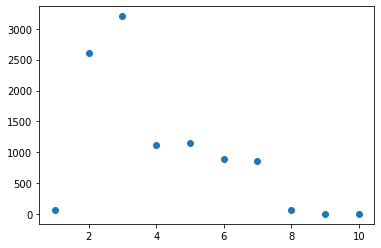

In [115]:
for i in range(2, 5):
    simulate(i)